# Distirbuted Hyperparameter Optimization with Dask

This is the accompanying notebook to the blog post [No More Coffee Breaks - Faster Hyperparameter Tuning in the Cloud](https://coiled.io/blog/faster-hyperparameter-tuning-cloud).

### Load data 

In [ ]:
import numpy as np
import pandas as pd

wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delimiter=";")

X, y = wine.iloc[:, :-1], wine["quality"]

In [ ]:
wine.shape

### 5-fold cross-validated XGBoost model

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

estimator = XGBRegressor(objective="reg:squarederror")
-cross_val_score(estimator, X, y, cv=5, scoring="neg_mean_absolute_error").mean()

### Local GridSearchCV (client machine)

In [ ]:
params = {
    "max_depth": [3, 16],
    "min_child_weight": [10, 30],
    "eta": [0.1, 0.05],
    "grow_policy": ["depthwise", "lossguide"],
}

In [ ]:
estimator = XGBRegressor(objective="reg:squarederror")

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=5,
    verbose=True,
)

In [ ]:
%%time
grid_search.fit(X, y)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

### GridSearchCV on a Dask `LocalCluster` (client machine)


This is equivalen to running local `GridSearchCV` with `sklearn`, except it can be useful to prototype the flow before running it on another cluster with more resources.

Feel free to skip this step and scale out to a bigger cluster!

In [ ]:
# from dask_ml.model_selection import GridSearchCV

# params = {
#     "max_depth": [3, 6, 8, 16],
#     "min_child_weight": [3, 5, 10, 20, 30],
#     "eta": [0.3, 0.2, 0.1, 0.05, 0.01],
#     "colsample_bytree": np.arange(0.7, 1.0, 0.1),
#     "sampling_method ": ["uniform", "gradient_based"],
#     "booster": ["gbtree", "dart"],
#     "grow_policy": ["depthwise", "lossguide"],
# }

# estimator = XGBRegressor(objective="reg:squarederror")

# grid_search = GridSearchCV(
#     estimator=estimator,
#     param_grid=params,
#     scoring="neg_mean_absolute_error",
#     n_jobs=-1,
#     cv=5,
# )

In [ ]:
# %%time
# grid_search.fit(X, y)

In [ ]:
# grid_search.best_score_

In [ ]:
# grid_search.best_params_

### GridSearchCV on a Dask cluster in the cloud - Coiled


In [2]:
import coiled
import joblib
from dask.distributed import Client

Set up a cluster of any size in 2 minutes. 

Go ahead and explore the configuration arguments for `coiled.Cluster()`!

In [ ]:
coiled.Cluster??

Get a cluster in the cloud

In [ ]:
%%time
cluster = coiled.Cluster(n_workers=24, software="optuna-xgboost")
client = Client(cluster)

client

In [ ]:
params = {
    "max_depth": [3, 6, 8, 16],
    "min_child_weight": [3, 5, 10, 20, 30],
    "eta": [0.3, 0.2, 0.1, 0.05, 0.01],
    "colsample_bytree": np.arange(0.7, 1.0, 0.1),
    "sampling_method ": ["uniform", "gradient_based"],
    "booster": ["gbtree", "dart"],
    "grow_policy": ["depthwise", "lossguide"],
}

#### 5 folds for each of 3200 candidates, totalling 16000 fits

In [ ]:
estimator = XGBRegressor(objective="reg:squarederror")

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=5,
    verbose=2,
)

`joblib`, the scikit-learn parallelization backend, will use our open cluster client connected to Coiled.

Make sure to launch the Dask Cluster dashboard, to see the tasks being worked on in real time!

In [ ]:
cluster.dashboard_link

In [ ]:
%%time
with joblib.parallel_backend("dask", scatter=[X, y]):
    grid_search.fit(X, y)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_estimator_

### Scale the cluster down

For next steps, the required resources will be much lower.

We can cut costs by scaling the cluster down right from this notebook:

In [ ]:
cluster.scale(4) # target = 4 workers

We can view the Cluster Dashboard to see workers disappearing and hourly cost coming down.

In [ ]:
cluster.dashboard_link

## Optuna

Bayesian optimization - accelerated search.

Let's configure the objective function to suggest parameter values from the ranges we want to explore.

In [ ]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "min_child_weight": trial.suggest_int("min_child_weight", 3, 30),
        "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "sampling_method ": trial.suggest_categorical(
            "sampling_method", ["uniform", "gradient_based"]
        ),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
    }

    wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delimiter=";")
    X, y = wine.iloc[:, :-1], wine["quality"]

    estimator = XGBRegressor(objective="reg:squarederror", **params)
    
    score = cross_val_score(
        estimator, X, y, cv=5, scoring="neg_mean_absolute_error"
    ).mean()
    
    return score

In [ ]:
%%time

import dask_optuna
import joblib
import optuna

storage = dask_optuna.DaskStorage()

study = optuna.create_study(direction="maximize", storage=storage)
with joblib.parallel_backend("dask"):
    study.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
study.best_value

In [ ]:
study.best_trial

In [ ]:
study.best_params

In [ ]:
results = study.trials_dataframe()

### Plot trial outcomes

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Mean Absolute Error over 100 Optimization Trials')

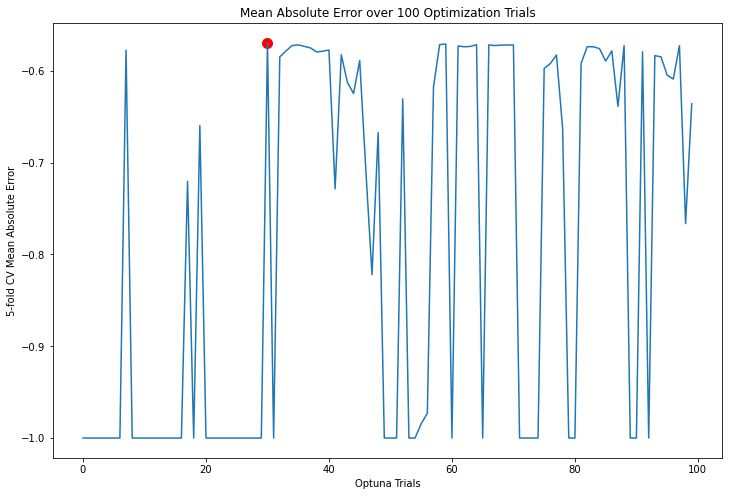

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
results.value.clip(lower=-1).plot.line()
best_trial = results.value.idxmax()
plt.scatter(best_trial, results.loc[best_trial].value, color='r', s=100)
plt.ylabel('5-fold CV Mean Absolute Error')
plt.xlabel('Optuna Trials')
plt.title('Mean Absolute Error over 100 Optimization Trials')

### Set down the cluster

In [ ]:
cluster.close()

### Dataset citation:

> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.  
> Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.